In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

from src.io.cache_io import temp_dir
from src.models.speclet_nine import SpecletNine

In [3]:
_ = gg.theme_set(gg.theme_classic())

In [4]:
def sample_pm_nb(mu: float, alpha: float, n: int = 500) -> np.ndarray:
    with pm.Model():
        x = pm.NegativeBinomial(name="x", mu=mu, alpha=alpha).random(size=n)
    return x

In [5]:
def sample_nb_with_params(
    params: list[tuple[float, float]], n: int = 500
) -> pd.DataFrame:
    dfs: list[pd.DataFrame] = []
    for mu, alpha in params:
        df = pd.DataFrame(
            {"mu": mu, "alpha": alpha, "draw": sample_pm_nb(mu, alpha, n=n)}
        )
        dfs.append(df)
    nb_samples = pd.concat(dfs)
    return nb_samples


def make_nb_counts_dataframe(
    params: list[tuple[float, float]], n: int = 500
) -> pd.DataFrame:
    nb_samples = sample_nb_with_params(params, n)
    nb_samples_counts = (
        nb_samples.value_counts(["mu", "alpha", "draw"])
        .to_frame("count")
        .reset_index(drop=False)
        .assign(label=lambda d: [f"mu: {m} alpha: {a}" for m, a in zip(d.mu, d.alpha)])
    )
    return nb_samples_counts

In [6]:
def plot_nb_sample_count(df: pd.DataFrame) -> gg.ggplot:
    return (
        gg.ggplot(df, gg.aes(x="draw", y="count", color="label"))
        + gg.geom_line(alpha=0.5)
        + gg.geom_point()
    )

Same parameters as used in the example in the PyMC3 documentation: [`NegativeBinomial`](https://docs.pymc.io/en/stable/api/distributions/discrete.html#pymc3.distributions.discrete.NegativeBinomial)

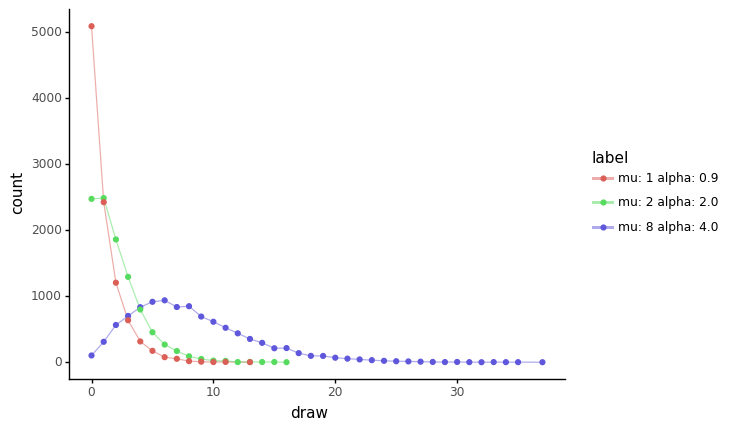

<ggplot: (359460356)>

In [7]:
params: list[tuple[float, float]] = [(1, 0.9), (2, 2), (8, 4)]
plot_nb_sample_count(make_nb_counts_dataframe(params, n=10000))

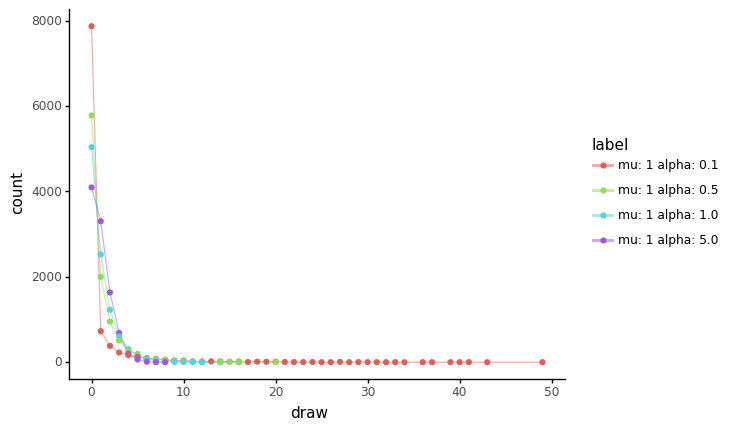

<ggplot: (359772046)>

In [8]:
params = [(1, 0.1), (1, 0.5), (1, 1.0), (1, 5.0)]
plot_nb_sample_count(make_nb_counts_dataframe(params, n=10000))

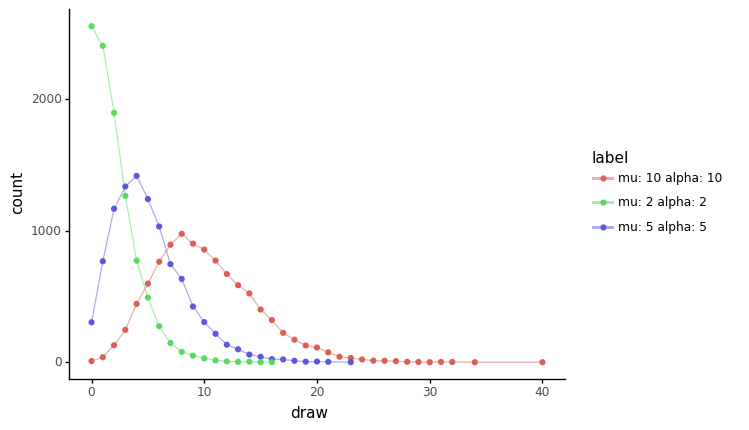

<ggplot: (360163536)>

In [9]:
params = [(2, 2), (5, 5), (10, 10)]
plot_nb_sample_count(make_nb_counts_dataframe(params, n=10000))

In [10]:
sample_nb_with_params([(1, 0.9), (2, 2), (8, 4)], n=100000).groupby(
    ["mu", "alpha"]
).agg(["mean", "std"])

draw          
             mean       std
mu alpha                   
1  0.9    0.99429  1.445385
2  2.0    2.00232  2.000014
8  4.0    7.99009  4.889455

In [11]:
make_nb_counts_dataframe([(0, 0.9)])

,mu,alpha,draw,count,label
0,0,0.9,0,500,mu: 0 alpha: 0.9


In [12]:
sp9 = SpecletNine("test-model", root_cache_dir=temp_dir())

[11/04/21 17:20:02] INFO     Creating a new SpecletNine object.            ]8;id=849398;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_nine.py\speclet_nine.py]8;;\:79

                    INFO     Adding new transformation.                  ]8;id=165654;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:172

                    INFO     Adding new transformation.                  ]8;id=274590;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:172

In [13]:
data = sp9.data_manager.get_data()
ct_i = np.abs(np.random.normal(loc=100, scale=5, size=data.shape[0])) + 1
# ct_i = np.ones(data.shape[0])
ct_f = np.abs(ct_i + np.random.normal(loc=0, scale=10, size=data.shape[0]))
data["counts_initial_adj"] = ct_i.astype(np.int64)
data["counts_final"] = ct_f.astype(np.int64)
sp9.data_manager.set_data(data, apply_transformations=False)

                    INFO     Getting data - reading from file.           ]8;id=206336;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:127

                    WARNING  Dropping 0 sgRNA that map to multiple genes.     ]8;id=153371;file:///Users/admin/Lab_Projects/speclet/src/data_processing/achilles.py\achilles.py]8;;\:616

                    INFO     Adding 'rna_expr_gene_lineage' column. ]8;id=906567;file:///Users/admin/Lab_Projects/speclet/src/modeling/feature_engineering.py\feature_engineering.py]8;;\:73

[11/04/21 17:20:03] INFO     Setting data.                               ]8;id=643722;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:143

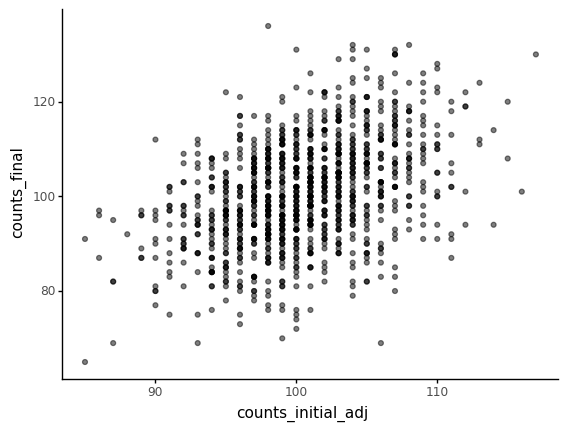

<ggplot: (360752297)>

In [14]:
(
    gg.ggplot(data, gg.aes(x="counts_initial_adj", y="counts_final"))
    + gg.geom_point(alpha=0.5)
)

In [15]:
sp9.build_model()

[11/04/21 17:20:04] INFO     Calling `model_specification()` method.     ]8;id=780707;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:148

                    INFO     Creating SpecletNine model.                  ]8;id=707358;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_nine.py\speclet_nine.py]8;;\:101

                    INFO     Getting data - already loaded.              ]8;id=939571;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:124

                    INFO     Number of data points: 1120                  ]8;id=77107;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_nine.py\speclet_nine.py]8;;\:105

                    INFO     Number of sgRNA: 160                         ]8;id=820127;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_nine.py\speclet_nine.py]8;;\:107

                    INFO     Number of genes: 101                         ]8;id=290466;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_nine.py\speclet_nine.py]8;;\:108

                    INFO     Number of cell lines: 7                      ]8;id=259926;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_nine.py\speclet_nine.py]8;;\:109

                    INFO     Number of lineages: 2                        ]8;id=293236;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_nine.py\speclet_nine.py]8;;\:110

                    INFO     Creating coordinates dictionary.             ]8;id=373800;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_nine.py\speclet_nine.py]8;;\:113

                    INFO     Building PyMC3 model.                        ]8;id=6727;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_nine.py\speclet_nine.py]8;;\:122

In [16]:
assert sp9.model is not None
with sp9.model:
    sp9_prior_pred = pm.sample_prior_predictive(random_seed=1234)

In [17]:
def plot_prior_pred(prior_samples: np.ndarray, scales: str = "fixed") -> gg.ggplot:
    """Plot prior predictive samples

    Args:
        prior_samples ([type]): Prior samples array with shape [samples, draws].

    Returns:
        gg.ggplot: A nice lil' plot for you and your buds.
    """
    prior_pred_df = (
        pd.DataFrame(prior_samples.T)
        .pivot_longer(names_to="prior_pred_sample", values_to="draw")
        .astype({"prior_pred_sample": "str"})
    )
    return (
        gg.ggplot(prior_pred_df, gg.aes(x="draw", fill="prior_pred_sample"))
        + gg.facet_wrap("prior_pred_sample", scales=scales)
        + gg.geom_histogram(bins=50, alpha=0.5, position="identity")
        + gg.scale_x_continuous(expand=(0, 0, 0.02, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.theme(figure_size=(8, 6), legend_position="none")
    )

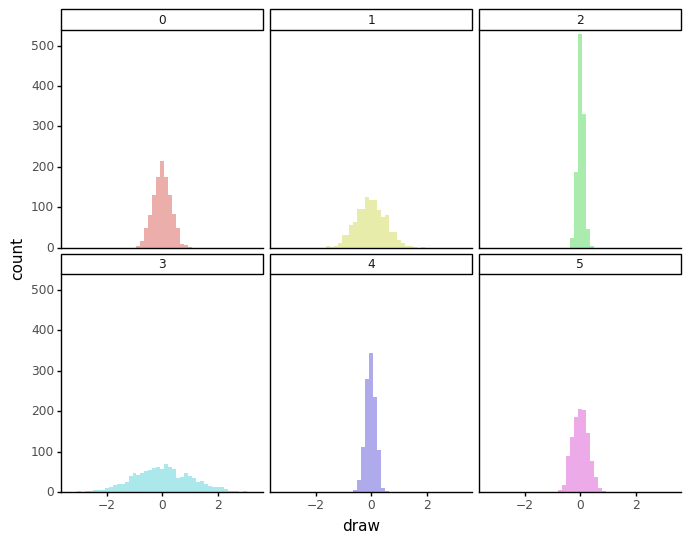

<ggplot: (361482704)>

In [18]:
plot_prior_pred(sp9_prior_pred["beta"][:6, :, :].reshape(6, -1))

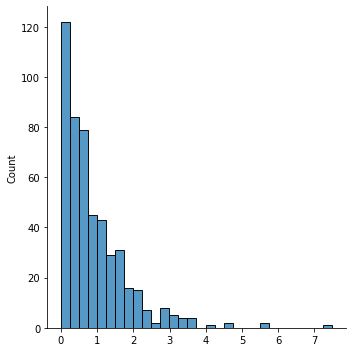

In [19]:
sns.displot(sp9_prior_pred["alpha"], kind="hist")
plt.show()

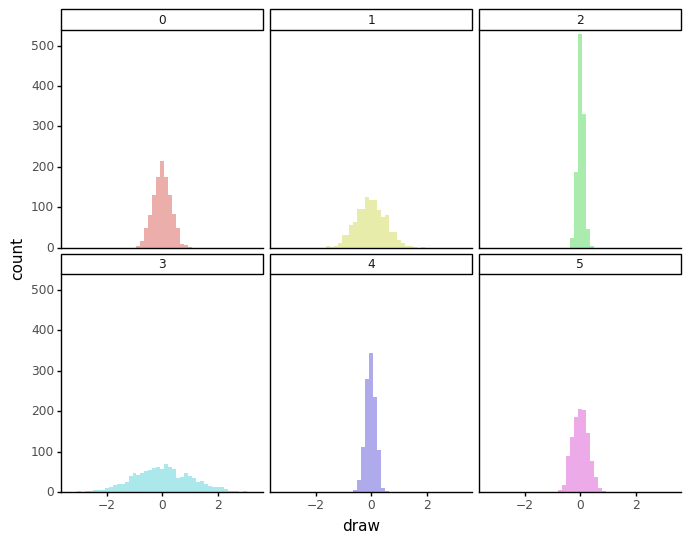

<ggplot: (360263340)>

In [20]:
plot_prior_pred(sp9_prior_pred["eta"][:6, :])

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


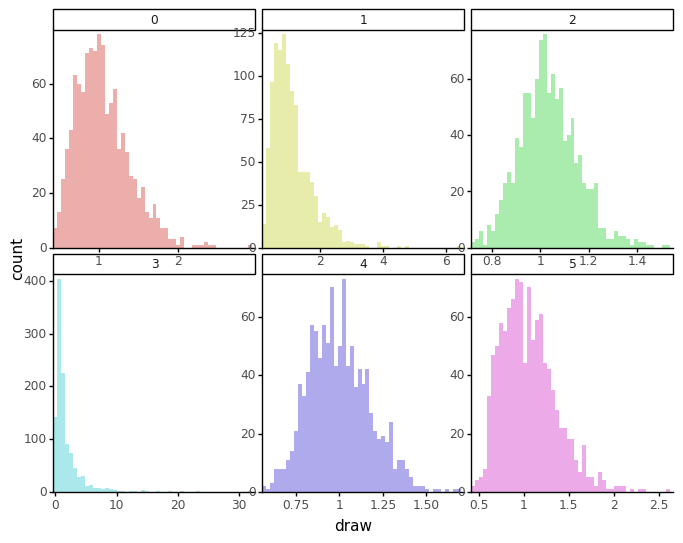

<ggplot: (359518618)>

In [21]:
plot_prior_pred(sp9_prior_pred["mu"][:6, :], scales="free")

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


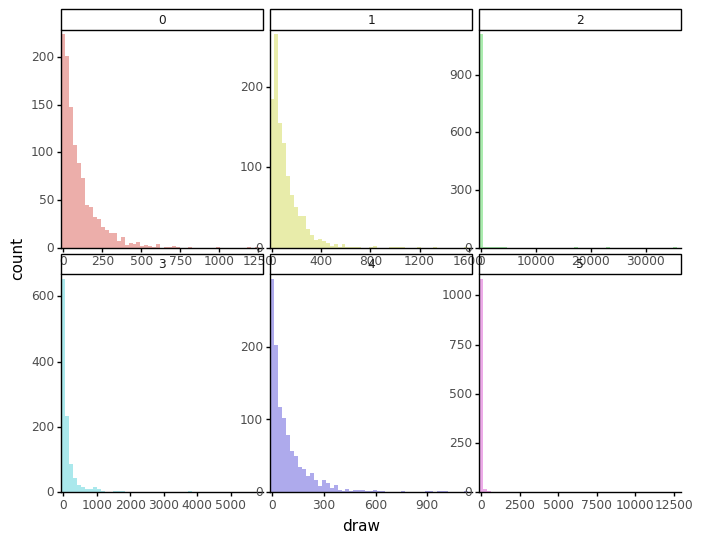

<ggplot: (360633733)>

In [22]:
(plot_prior_pred(sp9_prior_pred["y"][:6, :], scales="free"))

In [23]:
sp9_prior_pred["alpha"][:6]

array([0.6907363 , 1.04467459, 0.00184826, 0.42503755, 0.54317984,
       0.01076485])

In [24]:
sp9_prior_pred["mu"].mean(axis=1)[:6]

array([1.05134649, 1.13129421, 1.03404873, 1.79732576, 1.0004041 ,
       1.05510996])

**TODO**: split the Sp9 analysis into a later notebook